## 데이터셋 구경

In [18]:
import pandas as pd

df=pd.read_csv('metadata_with_Nan.csv')

filter = df[df['Shape_Feature'].isin(['C '])]

filter

,Name,Upper,Category,Shape_Feature,Description
12,BL-001,T,BL,C,스카이 블루 페일 톤 단색
29,BL-002,T,BL,C,아이보리 단색
51,BL-003,T,BL,C,화이트 단색
74,BL-004,T,BL,C,화이트 단색
92,BL-005,T,BL,C,화이트 단색
...,...,...,...,...,...
116967,VT-272,O,VT,C,아이보리 단색
116968,VT-272,O,VT,C,상의 가슴 부분 왼쪽 브라운 대비 색 포인트 배색
116969,VT-272,O,VT,C,상의 암홀 부분 브라운 대비 색 포인트 배색
116970,VT-272,O,VT,C,상의 앞 중심선 부분 오른쪽 브라운 대비 색 포인트 배색


## Feature Extraction - Clustering

In [1]:
import pandas as pd
from torch.utils.data import DataLoader

df=pd.read_csv('metadata_with_Nan.csv')
names = set(list(df['Name']))
print(names)
print(len(names))
names = pd.DataFrame(names, columns=['Name'])

{'KN-162', 'CT-497', 'BL-310', 'JK-383', 'JP-036', 'HC-099', 'HC-017', 'KN-507', 'CT-152', 'VT-209', 'BG-051', 'JK-188', 'KN-148', 'VT-250', 'CD-061', 'SK-071', 'CD-338', 'BL-269', 'JP-317', 'BG-003', 'SW-115', 'CT-480', 'SK-469', 'BG-251', 'BG-419', 'KN-372', 'SH-301', 'BL-138', 'HC-120', 'BG-065', 'CT-259', 'JK-211', 'OP-142', 'SW-320', 'HC-040', 'SH-073', 'CT-171', 'SK-462', 'JK-002', 'BG-356', 'KN-499', 'SE-316', 'SK-059', 'PT-193', 'PT-568', 'OP-065', 'BL-368', 'OP-189', 'PT-670', 'KN-219', 'BG-092', 'SW-105', 'JK-134', 'SW-131', 'BG-192', 'OP-115', 'SW-176', 'BL-351', 'SW-368', 'JK-100', 'SE-036', 'CD-037', 'JP-524', 'SE-349', 'SW-364', 'HC-103', 'BL-254', 'JP-614', 'HC-270', 'SC-059', 'JK-514', 'JP-430', 'PT-022', 'SE-261', 'KN-421', 'SC-097', 'CT-528', 'CD-071', 'PT-509', 'JP-588', 'PT-282', 'JK-087', 'PT-578', 'SH-056', 'PT-406', 'JP-529', 'KN-630', 'SH-010', 'SE-183', 'SW-027', 'SW-076', 'SE-029', 'CT-023', 'SK-454', 'VT-191', 'SE-307', 'JK-604', 'JP-503', 'JK-264', 'CD-131',

In [ ]:
from sklearn.model_selection import train_test_split
from tools.Fashiondataset import FashionDataset

#train_df, test_df = train_test_split(names, test_size=0.05, random_state=42)

image_folder = 'data/img_jpg'
Dataset=FashionDataset(dataframe=names, image_folder=image_folder)
Dataloader=DataLoader(Dataset, batch_size=4, shuffle=False)
#train_dataset = FashionDataset(dataframe=train_df, image_folder=image_folder)
#test_dataset = FashionDataset(dataframe=test_df, image_folder=image_folder)

#train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

c:\Users\user\anaconda3\envs\general2\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [ ]:
import torch
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.decomposition import PCA
from tools.FeatureEx import FeatureExtractor
from PIL import Image
from tools.ExFe import extract_features, extract_features_from_images

def perform_clustering(features, n_clusters=10):  
    print("K-means 클러스터링 수행 중...")     
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)     
    kmeans_labels = kmeans.fit_predict(features)          
    return kmeans_labels

def visualize_in_3d_with_scree_plot(features, labels):
    pca_full = PCA().fit(features)
    explained_variance = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
    n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
    n_components_70 = np.argmax(cumulative_variance >= 0.7) + 1
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.grid()
    
    plt.axvline(x=n_components_90, color='red', linestyle='--', label=f'90% Variance at PC {n_components_90}')
    plt.axvline(x=n_components_80, color='green', linestyle='--', label=f'80% Variance at PC {n_components_80}')
    plt.axvline(x=n_components_70, color='blue', linestyle='--', label=f'70% Variance at PC {n_components_70}')
    plt.legend()
    plt.show()
    
    pca = PCA(n_components=3)
    features_3d = pca.fit_transform(features)
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], 
                         c=labels, cmap='tab20c', s=15)
    
    ax.set_title('Clustered Feature 3D Visualization')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    
    legend = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend)
    
    plt.show()

In [4]:
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용하는 장치: {device}")

#feature_extractor_resnet = FeatureExtractor(model_type='resnet').to(device)
#feature_extractor_vit = FeatureExtractor(model_type='vit').to(device)
#feature_extractor_dino = FeatureExtractor(model_type='dino').to(device)
feature_extractor_deit = FeatureExtractor(model_type='deit').to(device)

#features_resnet = extract_features(train_loader, feature_extractor_resnet, device)
#features_vit = extract_features(train_loader, feature_extractor_vit, device)
#features_dino = extract_features(Dataloader, feature_extractor_dino, device)
features_deit = extract_features(Dataloader, feature_extractor_deit, device)

사용하는 장치: cuda


특징 추출:   0%|          | 0/1800 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\general2\Lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(
특징 추출: 100%|██████████| 1800/1800 [00:42<00:00, 42.64it/s]


In [5]:
original_labels = perform_clustering(features_deit, n_clusters=13)

print(original_labels)

K-means 클러스터링 수행 중...
[0 3 1 ... 5 1 9]


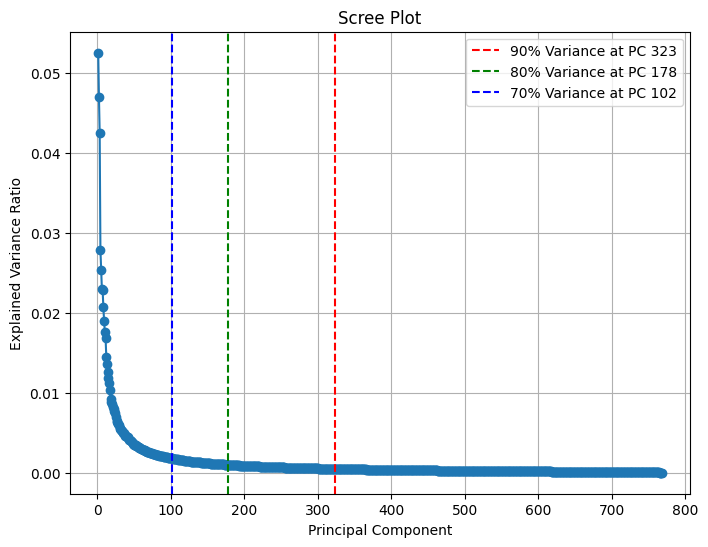

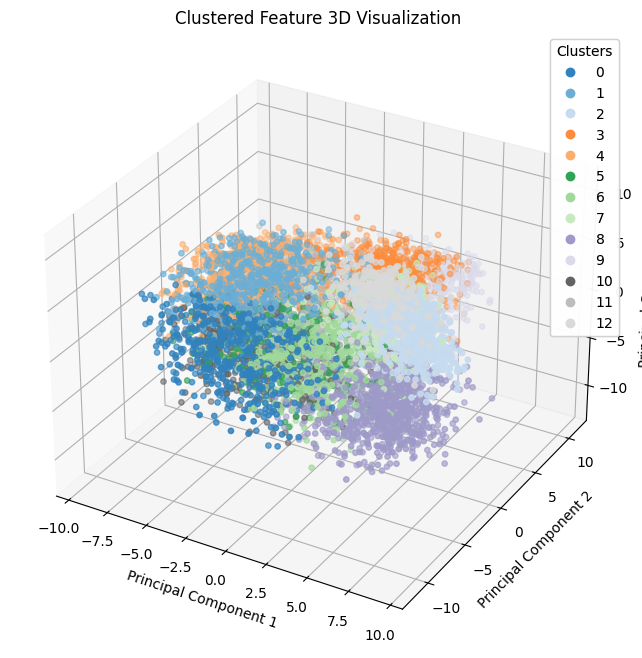

In [6]:
len(original_labels)
visualize_in_3d_with_scree_plot(features_deit,original_labels)

## Similarity check

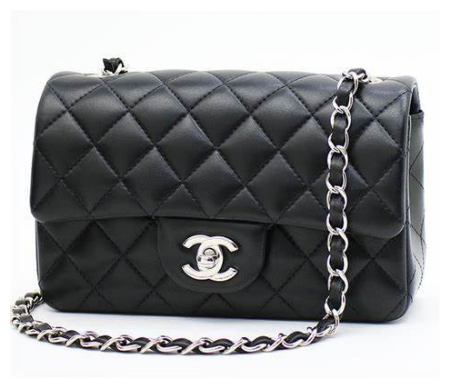

In [23]:
img_path = 'data/preference/CH-test1.jpg'
image = Image.open(img_path).convert('RGB')
plt.imshow(image)
plt.axis('off') 
plt.show()

In [24]:
feature_image = extract_features_from_images([img_path], feature_extractor_deit, device, transform=True)

Feature extraction: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


In [ ]:
from tools.similarity import get_sim
a=get_sim(features_deit, feature_image, Dataset, 10)

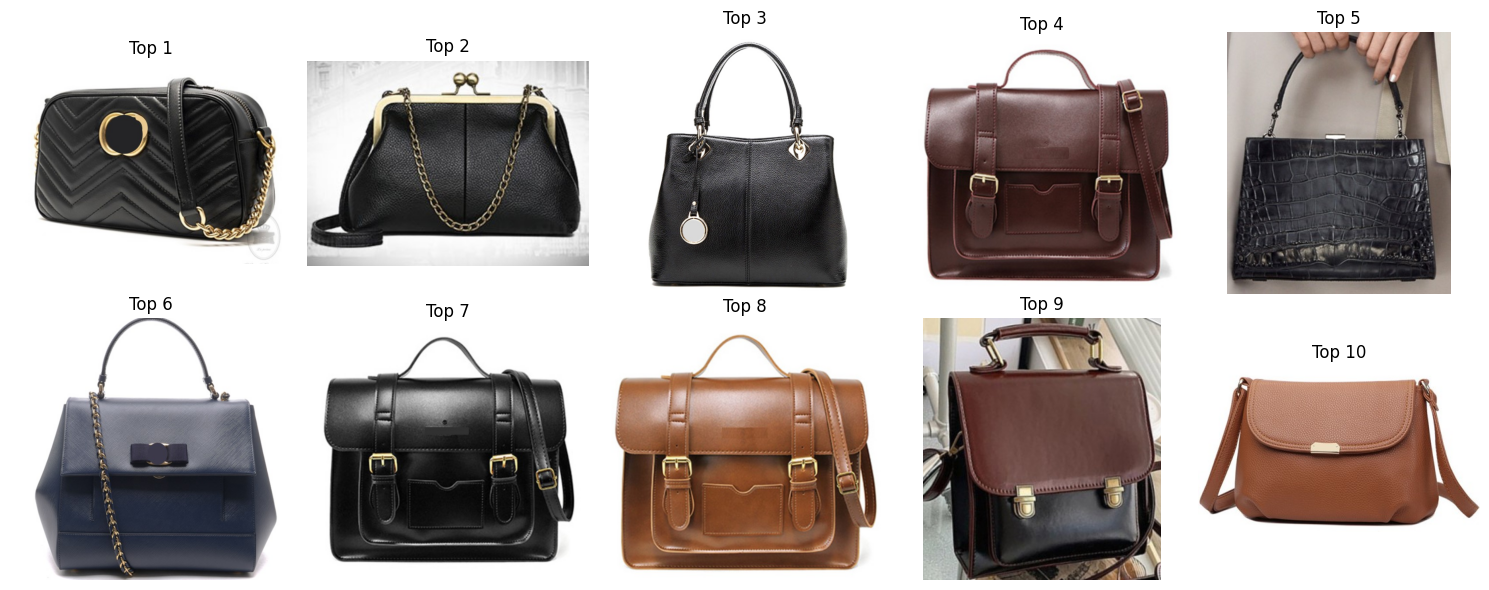

In [26]:
Dataset.show_images(a)